<a href="https://colab.research.google.com/github/jay-thakur/CIFER-10-Exploration/blob/main/CIFER_10_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
cd '/content/drive/MyDrive/All/MS/DM/Notebooks/Assignments'

/content/drive/MyDrive/All/MS/DM/Notebooks/Assignments


# TRAINING A CLASSIFIER on CIFER10 dataset

CIFER-10 is dataset of 32*32 size colored images by [CIFER Institute](https://www.cs.toronto.edu/~kriz/cifar.html), which consists 10 classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck').

## Steps to Train an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [38]:
# import all the required libraries
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

## 1. Loading and Normalizing CIFAR10

In [39]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's see some of the training images

Images Shape :  (3, 32, 32)


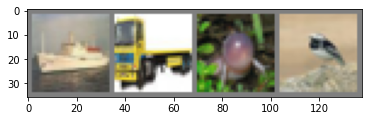

 ship truck  frog  bird


In [40]:
# function to show an image
def imshow(img):
  img = img / 2 + 0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get some training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

image_shape = images.numpy().shape[1:]
print("Images Shape : ", image_shape)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' %classes[labels[i]] for i in range(4)))

### 2. Define a Convolutional Neural Network

CNN consists of - 
1. Conv layer
2. Max Pool Layer
3. Fully Connected Layer

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [42]:
# Define a Neural Network with 2 convolution layer for 3 channel images 
class Net2CL(nn.Module):
  def __init__(self):
    super(Net2CL, self).__init__()

    # conv layers
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)

    # pooling layers
    self.pool = nn.MaxPool2d(2, 2)
    
    # fully connected layers
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = x.view(-1, 16 * 5 * 5)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net2cl = Net2CL()
net2cl = net2cl.to(device)

In [43]:
input_shape = image_shape # (3, 32, 32)
summary(net2cl, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [44]:
# Define a Neural Network with 3 convolution layer for 3 channel images 
class Net3CL(nn.Module):
  def __init__(self):
    super(Net3CL, self).__init__()

    # conv layers
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

    # pooling layers
    self.pool = nn.MaxPool2d(2, 2)
    
    # fully connected layers
    self.fc1 = nn.Linear(64 * 4 * 4, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    x = x.view(-1, 64 * 4 * 4)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net3cl = Net3CL()
net3cl = net3cl.to(device)
summary(net3cl, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 512]         524,800
            Linear-8                  [-1, 256]         131,328
            Linear-9                   [-1, 10]           2,570
Total params: 682,282
Trainable params: 682,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 2.60
Estimated Total Size (MB): 2.89
-------------------------------------------

In [104]:
# Define a Neural Network with 4 convolution layer for 3 channel images 
class Net4CL(nn.Module):
  def __init__(self):
    super(Net4CL, self).__init__()

        # conv layers
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

    # pooling layers
    self.pool = nn.MaxPool2d(2, 2)

    # dropout layer
    self.dropout = nn.Dropout(0.1)
    
    # fully connected layers
    self.fc1 = nn.Linear(64 * 4 * 4, 512)
    # self.fc2 = nn.Linear(512, 256)
    # self.fc3 = nn.Linear(256, 10)

    self.fc2 = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    x = x.view(-1, 64 * 4 * 4)

    # x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    # x = F.relu(self.fc2(x))
    # x = self.fc3(x)
    x = self.fc2(x)
    return x

net4cl = Net4CL()
net4cl = net4cl.to(device)

summary(net4cl, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                  [-1, 512]         524,800
           Dropout-8                  [-1, 512]               0
            Linear-9                   [-1, 10]           5,130
Total params: 553,514
Trainable params: 553,514
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 2.11
Estimated Total Size (MB): 2.40
-------------------------------------------

## 3. Define a Loss function and optimizer

### Different Loss functions


Regression
    Mean Absolute Error Loss(L1)
    Mean Squared Error Loss(L2)
    Binary Cross-Entropy Loss
    Cross-Entropy Loss
    Negative Log-Likelihood Loss
    Hinge Embedding Loss
    Margin Ranking Loss
    Triplet Margin Loss
    Kullback-Leibler divergence

Regression:

    Mean Absolute Error — torch.nn.L1Loss()
    Mean Squared Error — torch.nn.MSELoss()

Classification:

    Binary Cross Entropy Loss — torch.nn.BCELoss()
    Binary Cross Entropy with Logits Loss — torch.nn.BCEWithLogitsLoss()
    Negative Log Likelihood — torch.nn.NLLLoss()
    CrossEntropyLoss — torch.nn.CrossEntropyLoss()

https://heartbeat.fritz.ai/the-right-loss-function-pytorch-58d2c0d77404

https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

https://neptune.ai/blog/pytorch-loss-functions

In [46]:
def choose_loss_function(lf):
  if lf == "BCE":
    return nn.BCELoss()
  elif lf == "BCEwL":
    return nn.BCEWithLogitsLoss()
  elif lf == "NLL":
    return nn.NLLLoss()
  elif lf == "CE":
    return nn.CrossEntropyLoss()

### Different Optimizers

1. torch.optim.Adagrad
2. torch.optim.Adam
3. torch.optim.Adamax
4. torch.optim.ASGD
5. torch.optim.LBFGS
6. torch.optim.RMSProp
7. torch.optim.Rprop
8. torch.optim.SGD

https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/

In [47]:
learning_rate = 0.01

def choose_optimiser(net, optimiser):

  if optimiser == "Adam":
    return optim.Adam(net.parameters(), lr=learning_rate)
  elif optimiser == "Adamax":
    return optim.Adamax(net.parameters(), lr=learning_rate)
  elif optimiser == "ASGD":
    return optim.ASGD(net.parameters(), lr=learning_rate)
  elif optimiser == "LBFGS":
    return optim.LBFGS(net.parameters(), lr=learning_rate)
  elif optimiser == "RMSprop":
    return  optim.RMSprop(net.parameters(), lr=learning_rate)
  elif optimiser == "Rprop":
    return  optim.Rprop(net.parameters(), lr=learning_rate)
  elif optimiser == "SGD":
    return optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

### 4. Train the network

In [48]:
# Train the network
def fit(model, trainloader, optimizer, criterion):
  print("Training Started..")
  for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs
      inputs, labels = data

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward + backward + optimize
      outputs = model(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      #print statistics
      running_loss += loss.item()
      if i % 2000 == 1999: # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

  print("Training Finished.")


In [49]:
def choose_model(model):
  if model == "Net2CL":
    return Net2CL()
  elif model == "Net3CL":
    return Net3CL()
  elif model == "Net4CL":
    return Net4CL()

In [50]:
PATH = ''
def save_model(net, model):
  # lets save our trained model
  PATH = './cifer_'+net+'.pth'
  torch.save(model.state_dict(), PATH)

In [51]:
# SGD optimizer & Cross_Entropy_Loss
net = "Net2CL" # Net2CL - 2 conv layer net, Net3CL - 3 conv layer net, Net4CL - 4 conv layer net
model = choose_model(net)
opt = "SGD" # SGD - Stocastic, 
optimizer = choose_optimiser(model, opt)

lf = "CE" #CE - Cross Entropy, BCE - BCELoss, BCEwL - BCE with Logits loss, NLL - NLLLoss, 
criterion = choose_loss_function(lf)

fit(model, trainloader, optimizer, criterion)

save_model(net, model)

Training Started..
[1,  2000] loss: 2.247
[1,  4000] loss: 1.993
[1,  6000] loss: 1.743
[1,  8000] loss: 1.614
[1, 10000] loss: 1.542
[1, 12000] loss: 1.496
[2,  2000] loss: 1.424
[2,  4000] loss: 1.386
[2,  6000] loss: 1.353
[2,  8000] loss: 1.348
[2, 10000] loss: 1.317
[2, 12000] loss: 1.285
Training Finished.


### 5. Test the network on the test data

we have trained the network, now let's check if it has learnt anything

we will predict this by predicting the class label

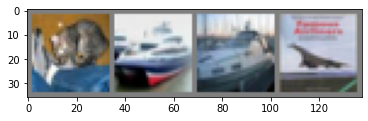

GroundTruth:    cat  ship  ship plane


In [52]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' %classes[labels[j]] for j in range(4)))

In [53]:
# model.load_state_dict(torch.load(PATH))

In [54]:
outputs = model(images)

In [55]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' %classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship  ship  ship


Lets see how the network performs on the whole dataset

In [56]:
# function to calcualte accuracy
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in dataloader:
      images, labels = data
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 10000 test images: %d%%' %(100*correct / total))

In [57]:
# total accuracy on test images
accuracy(model, testloader)

Accuracy of the network on the 10000 test images: 55%


let's see what are the classes performed well

In [58]:
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))
class_accuracy = list(0 for i in range(10))

def accuracy_of_classes(net, dataloader):
  with torch.no_grad():
    for data in dataloader:
      images, labels = data
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)
      c = (predicted == labels).squeeze()
      for i in range(4):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

  for i in range(10):
    class_accuracy[i] = 100 * class_correct[i] / class_total[i]
    print('Accuracy of %5s : %2d %%' %(classes[i], 100 * class_correct[i] / class_total[i]))

In [59]:
# accuracy of classes on test images
accuracy_of_classes(model, testloader)

Accuracy of plane : 44 %
Accuracy of   car : 61 %
Accuracy of  bird : 29 %
Accuracy of   cat : 31 %
Accuracy of  deer : 61 %
Accuracy of   dog : 41 %
Accuracy of  frog : 72 %
Accuracy of horse : 65 %
Accuracy of  ship : 72 %
Accuracy of truck : 71 %


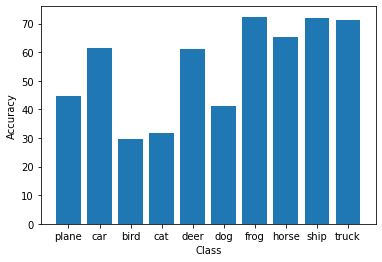

In [60]:
plt.bar(classes, class_accuracy)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.show()

In [61]:
# SGD optimizer & Cross_Entropy_Loss
net = "Net3CL" # Net2CL - 2 conv layer net, Net3CL - 3 conv layer net, Net4CL - 4 conv layer net
model = choose_model(net)
opt = "Adam" # SGD - Stocastic, 
optimizer = choose_optimiser(model, opt)

lf = "CE" #CE - Cross Entropy, BCE - BCELoss, BCEwL - BCE with Logits loss, NLL - NLLLoss, 
criterion = choose_loss_function(lf)

fit(model, trainloader, optimizer, criterion)

save_model(net, model)

Training Started..
[1,  2000] loss: 1.854
[1,  4000] loss: 1.518
[1,  6000] loss: 1.401
[1,  8000] loss: 1.332
[1, 10000] loss: 1.244
[1, 12000] loss: 1.188
[2,  2000] loss: 1.100
[2,  4000] loss: 1.058
[2,  6000] loss: 1.057
[2,  8000] loss: 1.045
[2, 10000] loss: 1.012
[2, 12000] loss: 1.010
Training Finished.


In [62]:
# total accuracy on test images
accuracy(model, testloader)

Accuracy of the network on the 10000 test images: 65%


In [105]:
# SGD optimizer & Cross_Entropy_Loss
net = "Net4CL" # Net2CL - 2 conv layer net, Net3CL - 3 conv layer net, Net4CL - 4 conv layer net
model = choose_model(net)

# opt = "Adam" # SGD - Stocastic, 
opt = "SGD" # SGD - Stocastic, 
optimizer = choose_optimiser(model, opt)
# optimizer = optim.Adam(Net4CL().parameters())

lf = "CE" #CE - Cross Entropy, BCE - BCELoss, BCEwL - BCE with Logits loss, NLL - NLLLoss, 
criterion = choose_loss_function(lf)

fit(model, trainloader, optimizer, criterion)

save_model(net, model)

Training Started..
[1,  2000] loss: 2.119
[1,  4000] loss: 1.743
[1,  6000] loss: 1.549
[1,  8000] loss: 1.443
[1, 10000] loss: 1.361
[1, 12000] loss: 1.281
[2,  2000] loss: 1.185
[2,  4000] loss: 1.140
[2,  6000] loss: 1.095
[2,  8000] loss: 1.041
[2, 10000] loss: 1.020
[2, 12000] loss: 1.019
Training Finished.


In [106]:
# total accuracy on test images
accuracy(model, testloader)

Accuracy of the network on the 10000 test images: 65%


In [107]:
# accuracy of classes on test images
accuracy_of_classes(model, testloader)

Accuracy of plane : 58 %
Accuracy of   car : 64 %
Accuracy of  bird : 41 %
Accuracy of   cat : 31 %
Accuracy of  deer : 49 %
Accuracy of   dog : 38 %
Accuracy of  frog : 75 %
Accuracy of horse : 54 %
Accuracy of  ship : 60 %
Accuracy of truck : 53 %


# References

https://www.cs.toronto.edu/~kriz/cifar.html

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-cnn-26a14c2ea29



